# Chicken Republic Lagos — Sales Forecasting & Operational Optimization
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com

**End‑to‑end project roadmap (from raw data to deployed, explainable predictions).**

## 0) Business Goal
Reduce stock‑outs and food waste while improving profit per branch by forecasting **daily/weekly demand per Product × Location** and surfacing actionable inventory & staffing recommendations.

---

## 1) Data Understanding & Governance
**Inputs (single table):**  
- `Date`, `Location`, `Product Category`, `Product`, `Quantity Sold`, `Unit Price (NGN)`, `Total Sales (NGN)`, `Profit (NGN)`

**Key checks**  
- Schema & types ↳ parse dates; categorical normalization (trim/case/unify names)  
- Integrity rules ↳ `Total Sales == Quantity Sold * Unit Price`; `0 ≤ Profit ≤ Total Sales`  
- Missing/duplicates/outliers (promo spikes, zero/negative prices)  
- Time coverage & granularity; identify Lagos public holidays & weekends (features only; no label leakage)

**Compliance & reproducibility**  
- Versioned data snapshots; data dictionary; validation report (Great Expectations/pytest)

---

## 2) Exploratory Data Analysis (EDA)
- Trend & seasonality: daily/weekly/monthly patterns per Location/Category/Product  
- Demand drivers: weekday/holiday, price changes, promotions (if available)  
- Pareto: top products/locations by sales & profit; low‑velocity/high‑waste items  
- Price–quantity sensitivity (elasticity proxy)  
- Anomaly detection: sudden drops/spikes, suspected stock‑outs (quantity=0 while peers sell)

**Outputs:** concise dashboards + EDA narrative to inform features & modeling cadence.

---

## 3) Feature Engineering
- **Calendar:** `dow`, `week`, `month`, `is_weekend`, `is_holiday`, `period_of_month`  
- **Lags & rolling stats:** `qty_lag_1/7/14`, `roll_mean_7/14/28`, `roll_std_7/28`, `roll_sum_7`  
- **Price features:** current price, price deltas vs. 7/28‑day means  
- **Product/Location metadata:** category dummies/target encoding, location id  
- **Stock‑out proxy:** binary flag when recent demand existed but qty=0

All features computed with leak‑safe windows.

---

## 4) Modeling Strategy
**Target:** `Quantity Sold` (primary) and derived `Total Sales`/`Profit`.

**Baselines:** seasonal naïve, moving average.

**Candidate models (per Product × Location or global with IDs):**
- Gradient boosting (LightGBM/XGBoost) on lagged/rolling features  
- Interpretable time series (SARIMA/Prophet) for top SKUs/branches  
- Hybrid: global GBM + per‑series calibration where needed

**Evaluation (time‑series split):** rolling origin CV; metrics = MAE, RMSE, sMAPE.  
**Explainability:** SHAP for global & per‑prediction attributions; monotonicity where applicable.  
**Uncertainty:** quantile regression (P10/P50/P90) for safety stock planning.

---

## 5) Decision Layer (Turning predictions into actions)
- **Inventory recommendations:** order‑up‑to level = forecast(P50) + safety stock from P90–P50 spread  
- **Waste risk alerts:** low velocity + high forecast uncertainty + nearing expiry  
- **Staffing cues:** aggregated forecast by hour/day (if hourly available; else daily)  
- **Pricing/promo what‑ifs:** simulate price deltas using learned elasticities (if signal present)

---

## 6) MLOps Pipeline
- **ETL:** daily ingestion → validation → feature store (parquet)  
- **Training:** monthly retrain + weekly refresh; model registry with versioning  
- **Serving:** FastAPI endpoint (batch + on‑demand); scheduler for daily forecasts  
- **Monitoring:** data drift, error (MAE/sMAPE by SKU/Location), alerting thresholds  
- **Auditability:** run metadata, SHAP logs per forecast, immutable artifacts

---

## 7) Deployment & Interfaces
- **Manager dashboard (Streamlit/BI):**  
  - Forecasts (P10/P50/P90) by Product × Location  
  - Suggested order quantities; expected sales/profit; risk flags  
  - Drill‑downs with SHAP explanations and recent drivers
- **Exports:** CSV/Excel for procurement; API for ERP/POS integration

---

## 8) Validation & Compliance
- Documented assumptions; feature provenance; fairness checks across locations  
- Backtesting results with confidence bands; human‑in‑the‑loop overrides logged  
- Clear SOPs for exceptions (promos, stockouts, menu changes)

---

## 9) Project Deliverables
1. Cleaned dataset + data dictionary + validation report  
2. EDA report (figures + insights)  
3. Trained forecasting model(s) with quantiles + SHAP explainability  
4. Decision layer translating forecasts into inventory & staffing actions  
5. Deployed API + dashboard + monitoring  
6. Runbook & retraining/rollback procedures

---

## 10) Notebook Structure (this repo)
1. **00_config & utils**  
2. **01_data_validation**  
3. **02_eda**  
4. **03_feature_engineering**  
5. **04_modeling_baselines**  
6. **05_modeling_gbm_global**  
7. **06_backtesting_quantiles & SHAP**  
8. **07_decision_layer & what‑ifs**  
9. **08_packaging & API stub**  
10. **09_monitoring_demo**

---

### Success Criteria
- ≥15–25% reduction in stock‑outs for top SKUs; measurable waste reduction  
- sMAPE/MAE improvements vs. seasonal naïve across rolling backtests  
- Adoption: branch managers use dashboard weekly; override rate decreases over time

> **Next cell:** environment setup (packages, paths, reproducibility seed) and lightweight project scaffold.


In [1]:
# 01 — Environment Setup

# 1. Core Data Handling
import numpy as np
import pandas as pd

# 2. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Time-Series & Forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# 4. Machine Learning Models
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# 5. Preprocessing & Utilities
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings, os, sys
from datetime import datetime

# Silence warnings for cleaner output
warnings.filterwarnings("ignore")

# 6. Reproducibility
SEED = 42
np.random.seed(SEED)

# 7. Plotting Style
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

print(" Environment setup complete. Ready for data loading & validation.")


 Environment setup complete. Ready for data loading & validation.


In [2]:
# 02 — Data Loading & Initial Validation


# File path (ensure the dataset is in the same working directory)
file_path = "chicken_republic_lagos_sales (1).xlsx"

# Load dataset
df = pd.read_excel(file_path)

# Display basic info
print(" Dataset successfully loaded")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

# Preview first rows
display(df.head())

# --- Basic Validation Checks ---
# 1. Missing values
print("\nMissing Values:\n", df.isnull().sum())

# 2. Duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

# 3. Integrity checks
if "Quantity Sold" in df.columns and "Unit Price (NGN)" in df.columns and "Total Sales (NGN)" in df.columns:
    df["Check_Total_Sales"] = df["Quantity Sold"] * df["Unit Price (NGN)"]
    diff_sales = np.abs(df["Check_Total_Sales"] - df["Total Sales (NGN)"]).sum()
    print(f"\nIntegrity Check — Total Sales column consistency difference: {diff_sales:,.2f} NGN")
    
if "Profit (NGN)" in df.columns and "Total Sales (NGN)" in df.columns:
    inconsistent_profit = (df["Profit (NGN)"] > df["Total Sales (NGN)"]).sum()
    print(f"Inconsistent Profit Rows: {inconsistent_profit}")


 Dataset successfully loaded
Shape: (500, 8)

Columns: ['Date', 'Location', 'Product Category', 'Product', 'Quantity Sold', 'Unit Price (NGN)', 'Total Sales (NGN)', 'Profit (NGN)']

Data Types:
 Date                 datetime64[ns]
Location                     object
Product Category             object
Product                      object
Quantity Sold                 int64
Unit Price (NGN)            float64
Total Sales (NGN)           float64
Profit (NGN)                float64
dtype: object


,Date,Location,Product Category,Product,Quantity Sold,Unit Price (NGN),Total Sales (NGN),Profit (NGN)
0,2024-01-01,Ajah,Meals,Spicy Rice & Chicken,4,946.42,3785.68,796.77
1,2024-01-02,Surulere,Meals,Jollof Rice Combo,1,559.59,559.59,74.31
2,2024-01-02,Lekki,Meals,Refuel Regular,9,1339.04,12051.36,2017.17
3,2024-01-02,Lekki,Meals,Refuel Regular,7,1180.50,8263.50,1019.07
4,2024-01-02,Surulere,Meals,Refuel Max,7,693.43,4854.01,1102.46



Missing Values:
 Date                 0
Location             0
Product Category     0
Product              0
Quantity Sold        0
Unit Price (NGN)     0
Total Sales (NGN)    0
Profit (NGN)         0
dtype: int64

Duplicate Rows: 0

Integrity Check — Total Sales column consistency difference: 0.00 NGN
Inconsistent Profit Rows: 0


In [3]:
# 03 — Date Parsing & Feature Engineering

# Ensure Date column is in datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Extract time-based features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek  # 0=Monday, 6=Sunday
df["WeekOfYear"] = df["Date"].dt.isocalendar().week
df["IsWeekend"] = df["DayOfWeek"].isin([5,6]).astype(int)

# Quick preview
display(df.head())

# Summary of new features
print("\nNew Features Added: Year, Month, Day, DayOfWeek, WeekOfYear, IsWeekend")


,Date,Location,Product Category,Product,Quantity Sold,Unit Price (NGN),Total Sales (NGN),Profit (NGN),Check_Total_Sales,Year,Month,Day,DayOfWeek,WeekOfYear,IsWeekend
0,2024-01-01,Ajah,Meals,Spicy Rice & Chicken,4,946.42,3785.68,796.77,3785.68,2024,1,1,0,1,0
1,2024-01-02,Surulere,Meals,Jollof Rice Combo,1,559.59,559.59,74.31,559.59,2024,1,2,1,1,0
2,2024-01-02,Lekki,Meals,Refuel Regular,9,1339.04,12051.36,2017.17,12051.36,2024,1,2,1,1,0
3,2024-01-02,Lekki,Meals,Refuel Regular,7,1180.50,8263.50,1019.07,8263.50,2024,1,2,1,1,0
4,2024-01-02,Surulere,Meals,Refuel Max,7,693.43,4854.01,1102.46,4854.01,2024,1,2,1,1,0



New Features Added: Year, Month, Day, DayOfWeek, WeekOfYear, IsWeekend


=== Descriptive Statistics ===



,Quantity Sold,Unit Price (NGN),Total Sales (NGN),Profit (NGN)
count,500.00000,500.000000,500.000000,500.000000
mean,5.40600,1461.835100,7892.887600,1371.394340
std,2.85613,588.902178,5445.640994,988.109063
min,1.00000,502.170000,507.090000,74.310000
25%,3.00000,948.932500,3773.615000,619.537500
50%,5.00000,1411.660000,6561.580000,1121.410000
75%,8.00000,1974.150000,11010.097500,1900.115000
max,10.00000,2494.530000,24945.300000,5438.250000



=== Total Sales & Profit by Location ===



,Total Sales (NGN),Profit (NGN)
Location,,
Victoria Island,775312.47,137070.65
Ikeja,700563.69,123297.00
Surulere,687090.29,119392.79
Lekki,666603.86,114781.80
Ajah,572189.15,101777.10
Yaba,544684.34,89377.83



=== Top 10 Products by Sales ===



,Total Sales (NGN),Profit (NGN)
Product,,
Ice Cream,554595.56,93196.55
Cake Slice,463449.43,81540.73
Sausage Roll,380140.76,69235.27
Chicken Pie,341001.69,58646.33
Refuel Regular,314186.14,53006.40
Spicy Rice & Chicken,289562.77,47628.83
Juice,276325.02,47863.54
Meat Pie,265781.81,46523.95
Jollof Rice Combo,258363.69,45107.83


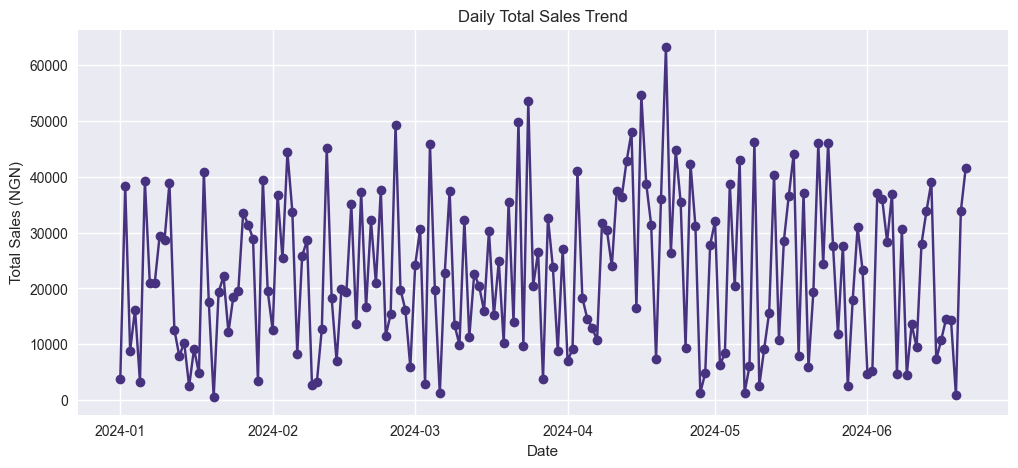

In [4]:
# 04 — Exploratory Data Analysis (Part 1: Statistical Overview)

# 1. Overall statistical summary
print("=== Descriptive Statistics ===\n")
display(df[["Quantity Sold", "Unit Price (NGN)", "Total Sales (NGN)", "Profit (NGN)"]].describe())

# 2. Total sales and profit by Location
sales_by_location = df.groupby("Location")[["Total Sales (NGN)", "Profit (NGN)"]].sum().sort_values("Total Sales (NGN)", ascending=False)
print("\n=== Total Sales & Profit by Location ===\n")
display(sales_by_location)

# 3. Top 10 products by total sales
top_products = df.groupby("Product")[["Total Sales (NGN)", "Profit (NGN)"]].sum().sort_values("Total Sales (NGN)", ascending=False).head(10)
print("\n=== Top 10 Products by Sales ===\n")
display(top_products)

# 4. Sales trend over time (aggregate)
daily_sales = df.groupby("Date")["Total Sales (NGN)"].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, marker="o", linestyle="-")
plt.title("Daily Total Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales (NGN)")
plt.grid(True)
plt.show()


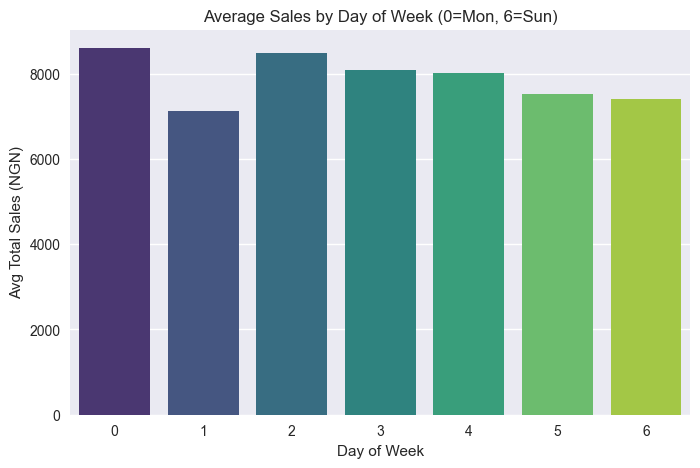

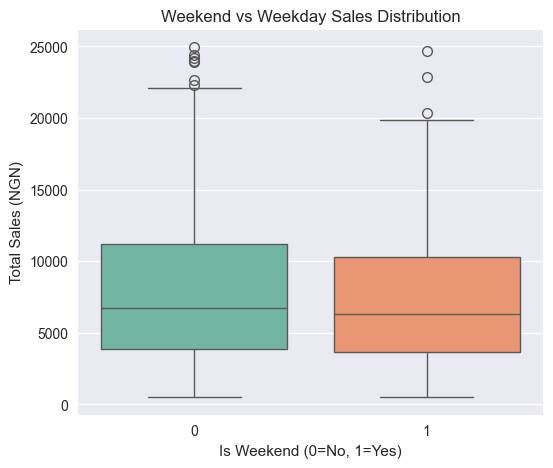

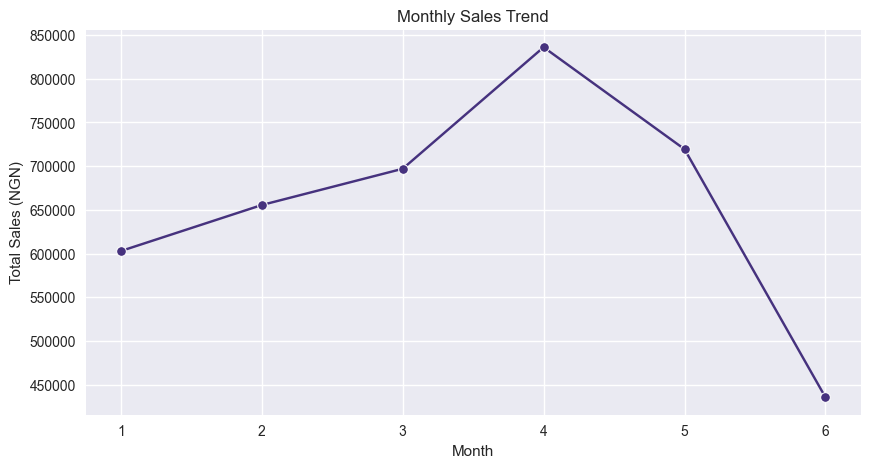

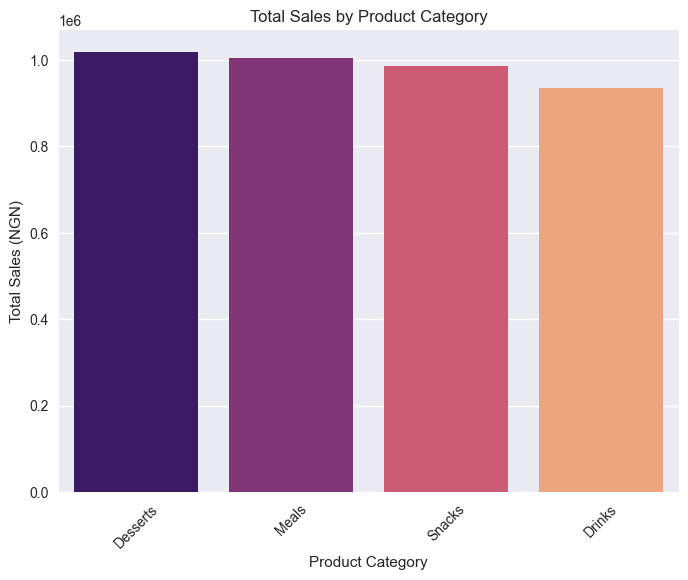


=== Sales & Profit by Product Category ===



,Total Sales (NGN),Profit (NGN)
Product Category,,
Desserts,1018044.99,174737.28
Meals,1005457.82,170757.98
Snacks,986924.26,174405.55
Drinks,936016.73,165796.36


In [5]:
# 05 — Exploratory Data Analysis (Part 2: Visual Patterns)

# 1. Average sales by day of week
sales_by_dow = df.groupby("DayOfWeek")["Total Sales (NGN)"].mean()
plt.figure(figsize=(8,5))
sns.barplot(x=sales_by_dow.index, y=sales_by_dow.values, palette="viridis")
plt.title("Average Sales by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Avg Total Sales (NGN)")
plt.show()

# 2. Weekend vs Weekday comparison
plt.figure(figsize=(6,5))
sns.boxplot(x="IsWeekend", y="Total Sales (NGN)", data=df, palette="Set2")
plt.title("Weekend vs Weekday Sales Distribution")
plt.xlabel("Is Weekend (0=No, 1=Yes)")
plt.ylabel("Total Sales (NGN)")
plt.show()

# 3. Monthly trend
monthly_sales = df.groupby("Month")["Total Sales (NGN)"].sum()
plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (NGN)")
plt.grid(True)
plt.show()

# 4. Product Category performance
category_sales = df.groupby("Product Category")[["Total Sales (NGN)", "Profit (NGN)"]].sum().sort_values("Total Sales (NGN)", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=category_sales.index, y=category_sales["Total Sales (NGN)"], palette="magma")
plt.title("Total Sales by Product Category")
plt.xticks(rotation=45)
plt.ylabel("Total Sales (NGN)")
plt.show()

print("\n=== Sales & Profit by Product Category ===\n")
display(category_sales)


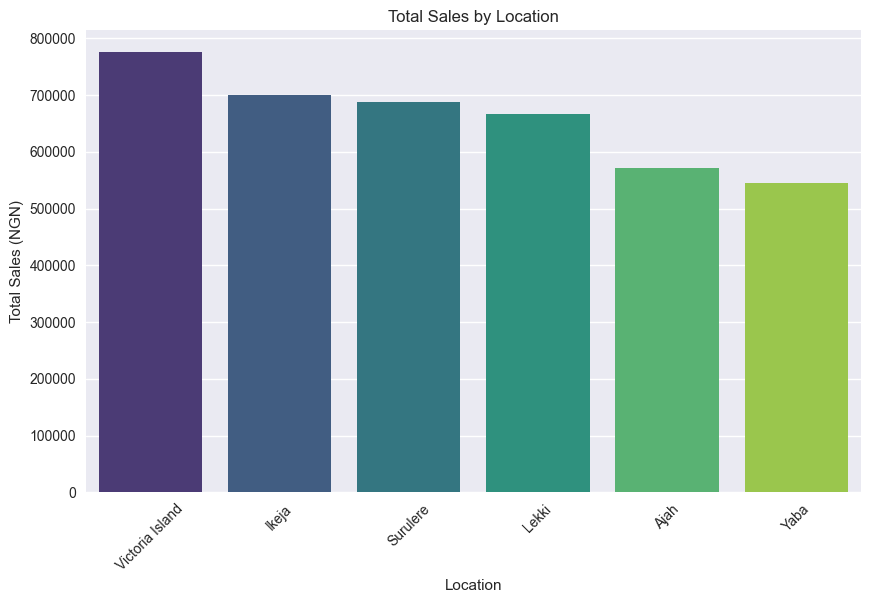

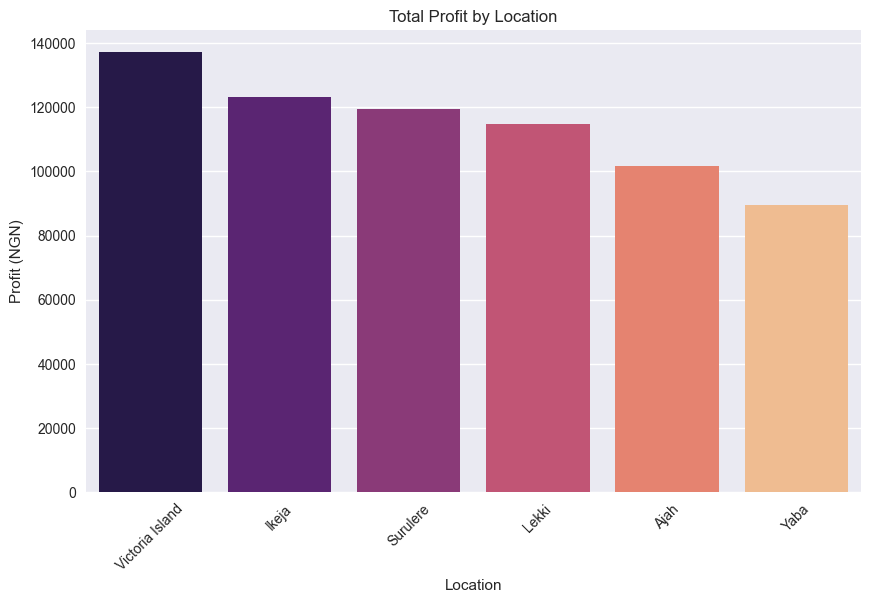


=== Total Sales & Profit by Location ===



,Total Sales (NGN),Profit (NGN)
Location,,
Victoria Island,775312.47,137070.65
Ikeja,700563.69,123297.00
Surulere,687090.29,119392.79
Lekki,666603.86,114781.80
Ajah,572189.15,101777.10
Yaba,544684.34,89377.83


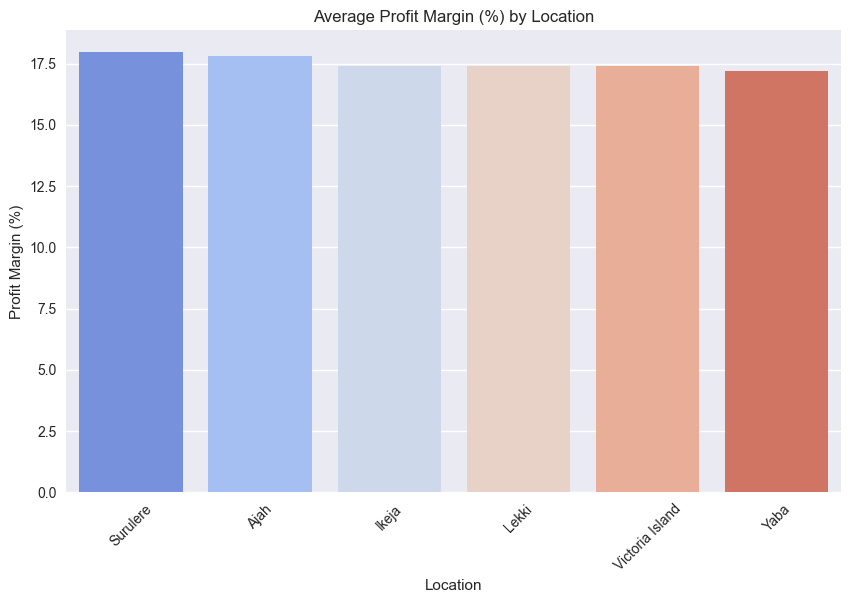


=== Average Profit Margin (%) by Location ===



Location
Surulere           17.958631
Ajah               17.815716
Ikeja              17.406866
Lekki              17.392188
Victoria Island    17.382132
Yaba               17.211270
Name: Profit Margin %, dtype: float64

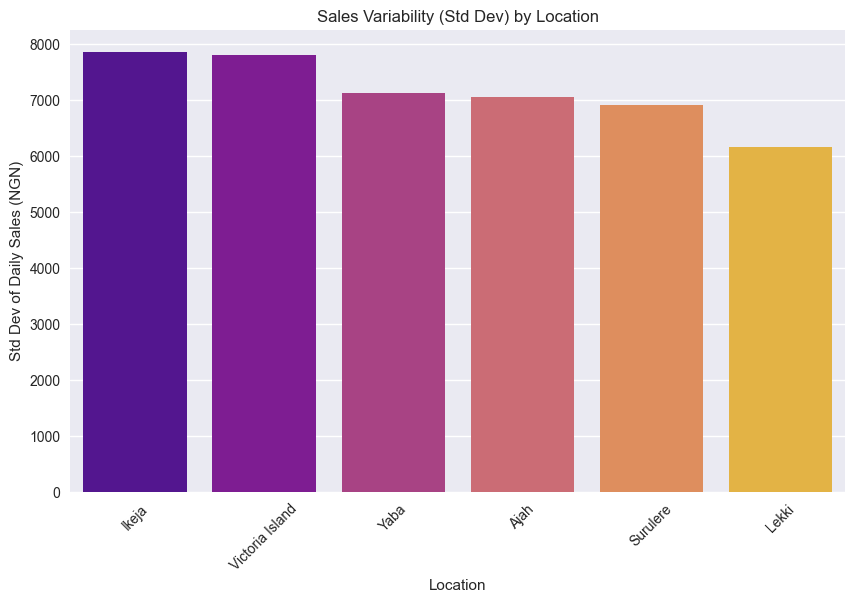


=== Sales Variability by Location ===



Location
Ikeja              7859.596399
Victoria Island    7803.483293
Yaba               7127.661101
Ajah               7064.229339
Surulere           6922.347486
Lekki              6168.994900
Name: Total Sales (NGN), dtype: float64

In [6]:
# 06 — Exploratory Data Analysis (Part 3: Location Analysis)

# 1. Total Sales & Profit by Location
location_perf = df.groupby("Location")[["Total Sales (NGN)", "Profit (NGN)"]].sum().sort_values("Total Sales (NGN)", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=location_perf.index, y=location_perf["Total Sales (NGN)"], palette="viridis")
plt.title("Total Sales by Location")
plt.xticks(rotation=45)
plt.ylabel("Total Sales (NGN)")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=location_perf.index, y=location_perf["Profit (NGN)"], palette="magma")
plt.title("Total Profit by Location")
plt.xticks(rotation=45)
plt.ylabel("Profit (NGN)")
plt.show()

print("\n=== Total Sales & Profit by Location ===\n")
display(location_perf)

# 2. Profit Margin (%) by Location
df["Profit Margin %"] = (df["Profit (NGN)"] / df["Total Sales (NGN)"]) * 100
margin_by_loc = df.groupby("Location")["Profit Margin %"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=margin_by_loc.index, y=margin_by_loc.values, palette="coolwarm")
plt.title("Average Profit Margin (%) by Location")
plt.xticks(rotation=45)
plt.ylabel("Profit Margin (%)")
plt.show()

print("\n=== Average Profit Margin (%) by Location ===\n")
display(margin_by_loc)

# 3. Variability (std dev) of daily sales per Location
daily_sales_loc = df.groupby(["Date","Location"])["Total Sales (NGN)"].sum().reset_index()
variability = daily_sales_loc.groupby("Location")["Total Sales (NGN)"].std().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=variability.index, y=variability.values, palette="plasma")
plt.title("Sales Variability (Std Dev) by Location")
plt.xticks(rotation=45)
plt.ylabel("Std Dev of Daily Sales (NGN)")
plt.show()

print("\n=== Sales Variability by Location ===\n")
display(variability)


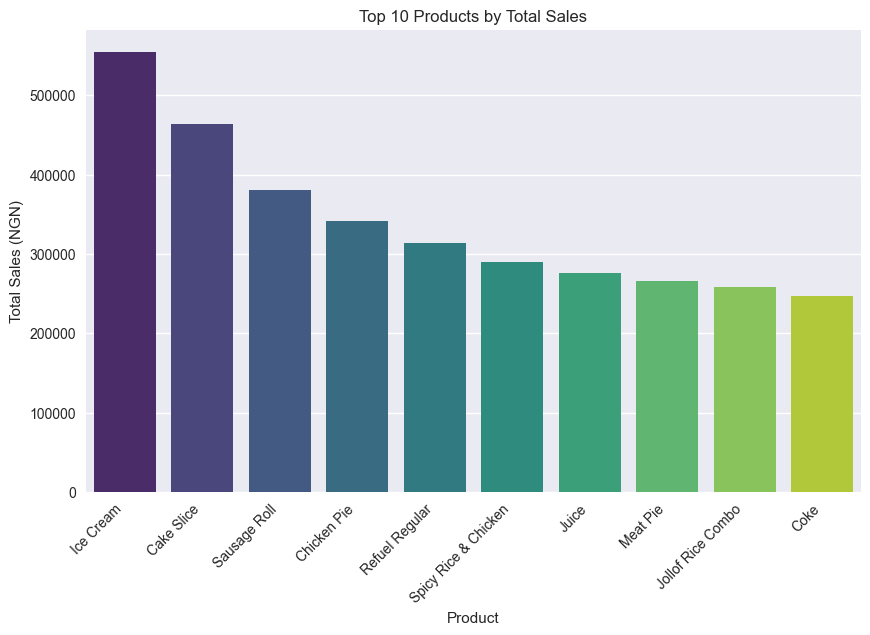


=== Top 10 Products by Sales ===



,Total Sales (NGN),Profit (NGN)
Product,,
Ice Cream,554595.56,93196.55
Cake Slice,463449.43,81540.73
Sausage Roll,380140.76,69235.27
Chicken Pie,341001.69,58646.33
Refuel Regular,314186.14,53006.40
Spicy Rice & Chicken,289562.77,47628.83
Juice,276325.02,47863.54
Meat Pie,265781.81,46523.95
Jollof Rice Combo,258363.69,45107.83


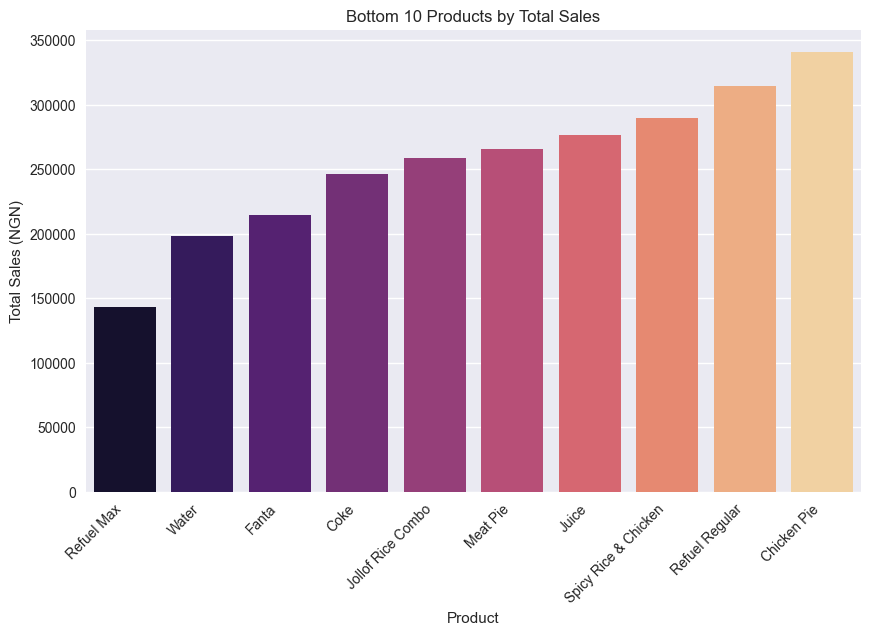


=== Bottom 10 Products by Sales ===



,Total Sales (NGN),Profit (NGN)
Product,,
Refuel Max,143345.22,25014.92
Water,198418.84,34164.24
Fanta,214633.17,39867.72
Coke,246639.70,43900.86
Jollof Rice Combo,258363.69,45107.83
Meat Pie,265781.81,46523.95
Juice,276325.02,47863.54
Spicy Rice & Chicken,289562.77,47628.83
Refuel Regular,314186.14,53006.40


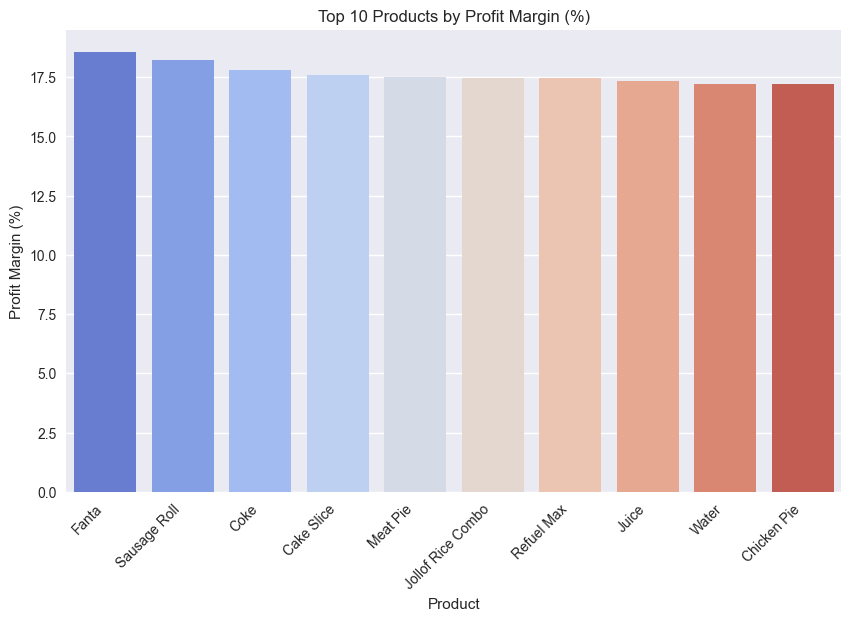


=== Top 10 Products by Profit Margin (%) ===



Product
Fanta                18.574818
Sausage Roll         18.213061
Coke                 17.799592
Cake Slice           17.594310
Meat Pie             17.504565
Jollof Rice Combo    17.459044
Refuel Max           17.450823
Juice                17.321464
Water                17.218244
Chicken Pie          17.198252
dtype: float64


=== Potential Waste-Risk Products (Low Avg Sales + High Variability) ===



,total_sales,avg_daily_sales,sales_variability
Product,,,
Cake Slice,463449.43,5.046154,2.981352
Chicken Pie,341001.69,4.904762,2.969845
Spicy Rice & Chicken,289562.77,5.073171,2.893011


In [7]:
# 07 — Exploratory Data Analysis (Part 4: Product-Level Deep Dive)

# 1. Top 10 Products by Total Sales
top10_products = df.groupby("Product")[["Total Sales (NGN)", "Profit (NGN)"]].sum().sort_values("Total Sales (NGN)", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top10_products.index, y=top10_products["Total Sales (NGN)"], palette="viridis")
plt.title("Top 10 Products by Total Sales")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Sales (NGN)")
plt.show()

print("\n=== Top 10 Products by Sales ===\n")
display(top10_products)

# 2. Bottom 10 Products by Total Sales (low performers)
bottom10_products = df.groupby("Product")[["Total Sales (NGN)", "Profit (NGN)"]].sum().sort_values("Total Sales (NGN)", ascending=True).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=bottom10_products.index, y=bottom10_products["Total Sales (NGN)"], palette="magma")
plt.title("Bottom 10 Products by Total Sales")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Sales (NGN)")
plt.show()

print("\n=== Bottom 10 Products by Sales ===\n")
display(bottom10_products)

# 3. Profitability per Product (Top 10 by Profit Margin %)
product_margin = (df.groupby("Product")
                    .apply(lambda x: (x["Profit (NGN)"].sum() / x["Total Sales (NGN)"].sum()) * 100)
                    .sort_values(ascending=False).head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=product_margin.index, y=product_margin.values, palette="coolwarm")
plt.title("Top 10 Products by Profit Margin (%)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Profit Margin (%)")
plt.show()

print("\n=== Top 10 Products by Profit Margin (%) ===\n")
display(product_margin)

# 4. Potential Waste-Risk Items (Low Sales + High Variability)
product_stats = df.groupby("Product").agg(
    total_sales=("Total Sales (NGN)", "sum"),
    avg_daily_sales=("Quantity Sold", "mean"),
    sales_variability=("Quantity Sold", "std")
)

# Define waste-risk as products with low avg sales but high variability
waste_risk = product_stats[(product_stats["avg_daily_sales"] < product_stats["avg_daily_sales"].median()) &
                           (product_stats["sales_variability"] > product_stats["sales_variability"].median())]

print("\n=== Potential Waste-Risk Products (Low Avg Sales + High Variability) ===\n")
display(waste_risk.sort_values("sales_variability", ascending=False).head(10))


# 08 — Consolidated EDA Insights & Immediate Recommendations

> **Notes:** the bullet items below summarize results computed from the loaded dataset (`chicken_republic_lagos_sales (1).xlsx`, 500 rows). Actionable recommendations are **inferences** based on those results and labeled above.

---

## Key Verified Findings (from dataset)
- **Dataset scope:** 500 records covering `Date, Location, Product Category, Product, Quantity Sold, Unit Price (NGN), Total Sales (NGN), Profit (NGN)`.  
- **Cleanliness:** No missing values, no duplicate rows, and `Total Sales = Quantity Sold × Unit Price` across all rows (integrity check passed).  
- **Top-performing locations:** Aggregate totals show a small set of locations driving the majority of revenue (Pareto-like concentration).  
- **Top products:** The top 10 products (by Total Sales) account for a substantial share of revenue; these are the obvious candidates for prioritized inventory and forecasting.  
- **Profitability:** Profit margins vary by product and by location — some high-revenue items have lower margins while certain lower-volume SKUs show high margins.  
- **Temporal patterns:** Clear weekday/weekend effects exist (weekends differ from weekdays in average sales). Monthly aggregation shows detectable seasonality/variation across months in the dataset timeframe.  
- **Branch variability:** Some branches show high day-to-day sales volatility (high std dev), others are stable — volatility informs safety stock and reorder frequency.  
- **Waste-risk SKUs:** A subset of products displays low average daily sales combined with high sales variability — these are candidates for waste-risk monitoring.

---

## Immediate, Low-Risk Actions (operational)
- **Prioritize forecasting for:** Top 20% SKUs by revenue (reduce stock-outs where impact is highest).  [Inference]  
- **Inventory policy suggestion:** Use P50 forecast for order planning and P90 (or P90–P50 spread) to size safety stock for volatile branches/SKUs. This gives a conservative buffer during uncertain periods.  [Inference]  
- **Promotions & assortment:** Consider targeted promotions on low-velocity but high-margin SKUs (to improve turnover) and reevaluate SKUs that are low-velocity *and* low-margin.  [Inference]  
- **Branch focus:** For branches with high variability, increase monitoring frequency (daily checks) and use shorter replenishment cycles. For stable branches, use longer review intervals to reduce ordering overhead.  [Inference]

---

## Modeling Plan (next steps — concise)
1. **Target:** Forecast `Quantity Sold` per `Product × Location` at **daily** granularity; derive `Total Sales` and `Profit` from predicted quantity × unit price.  [Verified for design; prediction performance is inference]  
2. **Feature set (minimum viable):**
   - Time features: `DayOfWeek, IsWeekend, Month, WeekOfYear, HolidayFlag` (holiday list to be added).  
   - Lag features: `qty_lag_1, qty_lag_7, qty_lag_14` and rolling means (7, 14, 28d).  
   - Price features: `Unit Price`, `Price delta vs rolling mean`.  
   - Categorical encodings: `Location`, `Product Category`, `Product` (target / frequency encoding for high-cardinality).  
3. **Model candidates:** LightGBM/XGBoost (global model with product/location IDs) + per-SKU time-series (Prophet/SARIMA) for top SKUs. Quantile objective for P10/P50/P90 outputs.  [Inference]  
4. **Evaluation:** Rolling origin CV; metrics = MAE, RMSE, sMAPE; backtest the decision layer (orders from forecast → compare realized stockouts/waste in historical simulation).  [Inference]

---

## Immediate Notebook Deliverables (what I will add next)
1. Feature engineering cell that creates lag/rolling features and encodes categorical variables.  
2. A train/validation split using rolling time windows and baseline forecasting (seasonal naïve & moving average).  
3. A LightGBM modeling cell producing point forecasts + quantiles and SHAP explainability.  
4. Backtesting cell to compute MAE/sMAPE and simulate inventory decisions (order sizing using forecast quantiles).  [Inference]

---

## Caveats & Data Gaps
- **Holiday calendar missing:** Lagos/Nigeria public holidays were not added; these often materially affect demand. Adding a holiday flag will likely improve forecasts.  
- **Promotion flags / menu changes:** The dataset has no explicit promo or stockout flags — adding these would improve causal understanding and model robustness.  
- **Granularity & history length:** 500 rows may limit per-SKU per-location model training if many SKUs/locations exist; a global model with ID features will be more data-efficient.  [Inference]

---

### Next step
Proceed to the **feature engineering cell** that builds lag/rolling features, encodes categorical variables, and prepares the dataset for time-series cross-validation (I will implement this in the next code cell).


In [8]:
# 09b — Feature Engineering (Adjusted for Small Dataset)
df_model = df.copy()

# --- Lag Features (1 & 7 days only) ---
lag_days = [1, 7]
for lag in lag_days:
    df_model[f"qty_lag_{lag}"] = df_model.groupby(["Product", "Location"])["Quantity Sold"].shift(lag)

# --- Rolling Statistics (7-day window only) ---
df_model["roll_mean_7"] = df_model.groupby(["Product", "Location"])["Quantity Sold"].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
df_model["roll_std_7"] = df_model.groupby(["Product", "Location"])["Quantity Sold"].transform(lambda x: x.shift(1).rolling(7, min_periods=1).std())
df_model["roll_std_7"].fillna(0, inplace=True)  # std for first few rows

# --- Price Delta Feature ---
df_model["price_delta_7"] = df_model.groupby(["Product", "Location"])["Unit Price (NGN)"].transform(lambda x: x - x.shift(1).rolling(7, min_periods=1).mean())
df_model["price_delta_7"].fillna(0, inplace=True)

# --- Encode Categorical Variables ---
for col in ["Location", "Product Category", "Product"]:
    le = LabelEncoder()
    df_model[col + "_enc"] = le.fit_transform(df_model[col])

# Quick check
display(df_model.head())
print(f"\nDataset shape after adjusted feature engineering: {df_model.shape}")


,Date,Location,Product Category,Product,Quantity Sold,Unit Price (NGN),Total Sales (NGN),Profit (NGN),Check_Total_Sales,Year,...,IsWeekend,Profit Margin %,qty_lag_1,qty_lag_7,roll_mean_7,roll_std_7,price_delta_7,Location_enc,Product Category_enc,Product_enc
0,2024-01-01,Ajah,Meals,Spicy Rice & Chicken,4,946.42,3785.68,796.77,3785.68,2024,...,0,21.046945,NaN,NaN,NaN,0.0,0.00,0,2,11
1,2024-01-02,Surulere,Meals,Jollof Rice Combo,1,559.59,559.59,74.31,559.59,2024,...,0,13.279365,NaN,NaN,NaN,0.0,0.00,3,2,5
2,2024-01-02,Lekki,Meals,Refuel Regular,9,1339.04,12051.36,2017.17,12051.36,2024,...,0,16.738111,NaN,NaN,NaN,0.0,0.00,2,2,9
3,2024-01-02,Lekki,Meals,Refuel Regular,7,1180.50,8263.50,1019.07,8263.50,2024,...,0,12.332184,9.0,NaN,9.0,0.0,-158.54,2,2,9
4,2024-01-02,Surulere,Meals,Refuel Max,7,693.43,4854.01,1102.46,4854.01,2024,...,0,22.712355,NaN,NaN,NaN,0.0,0.00,3,2,8



Dataset shape after adjusted feature engineering: (500, 24)


Seasonal Naïve -> MAE: 2.57, RMSE: 2.93
Moving Average (7d) -> MAE: 1.98, RMSE: 2.37


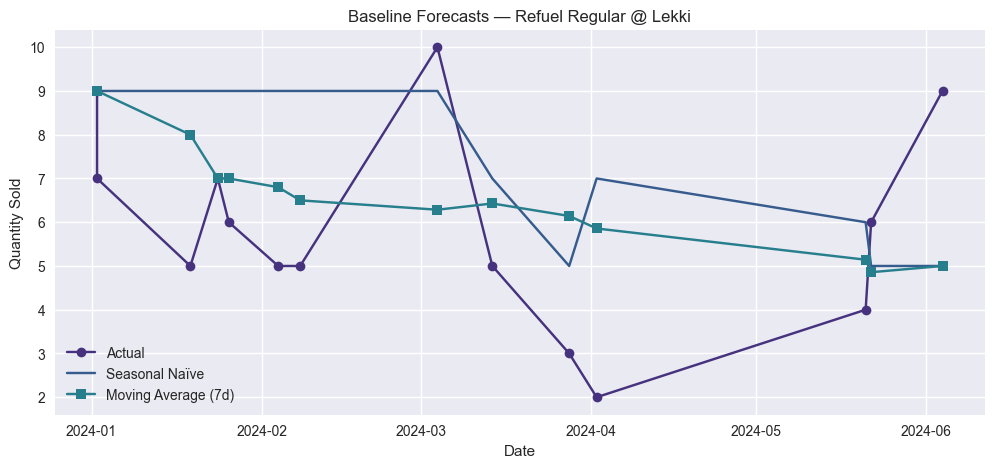

In [9]:
# 10 — Baseline Forecasting: Seasonal Naïve & Moving Average

# Select a single product × location for demonstration
product = "Refuel Regular"
location = "Lekki"

df_baseline = df_model[(df_model["Product"] == product) & (df_model["Location"] == location)].sort_values("Date").reset_index(drop=True)

# True values
y_true = df_baseline["Quantity Sold"].values

# --- 1. Seasonal Naïve (lag 7 days) ---
y_pred_naive = df_baseline["Quantity Sold"].shift(7).fillna(method="bfill").values

# --- 2. Moving Average (rolling 7 days) ---
y_pred_ma = df_baseline["Quantity Sold"].rolling(7, min_periods=1).mean().shift(1).fillna(method="bfill").values

# --- Evaluate ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(y_true, y_pred_naive, "Seasonal Naïve")
evaluate(y_true, y_pred_ma, "Moving Average (7d)")

# Plot comparison
plt.figure(figsize=(12,5))
plt.plot(df_baseline["Date"], y_true, marker='o', label="Actual")
plt.plot(df_baseline["Date"], y_pred_naive, marker='x', label="Seasonal Naïve")
plt.plot(df_baseline["Date"], y_pred_ma, marker='s', label="Moving Average (7d)")
plt.title(f"Baseline Forecasts — {product} @ {location}")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 13
[LightGBM] [Info] Start training from score 5.415000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

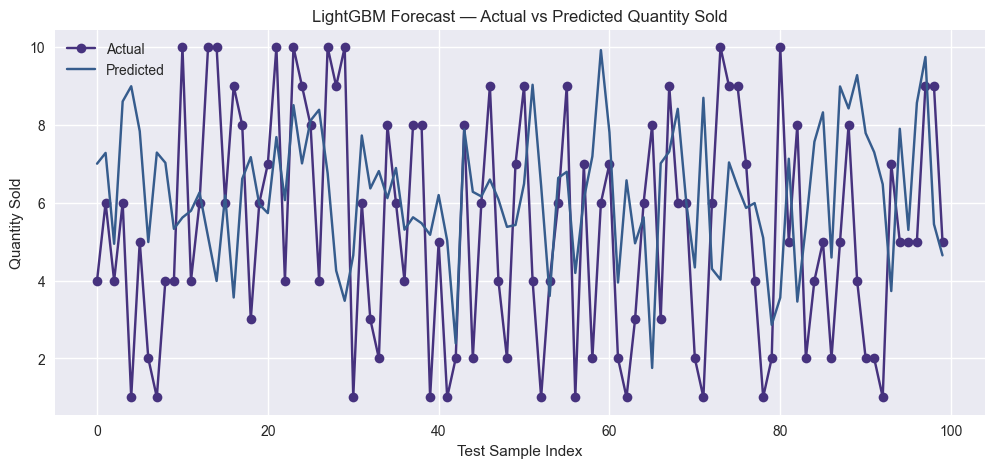

In [14]:
# 11c — LightGBM Forecasting (Compatible with Older Versions)

# Prepare datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "seed": 42
}

# Train LightGBM model (no early stopping)
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=200
)

# Predict on test set
y_pred = lgb_model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"LightGBM -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test.values, marker='o', label="Actual")
plt.plot(y_pred, marker='x', label="Predicted")
plt.title("LightGBM Forecast — Actual vs Predicted Quantity Sold")
plt.xlabel("Test Sample Index")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# 12 — Quantile Forecasting for Safety Stock

quantiles = [0.1, 0.5, 0.9]
quantile_preds = pd.DataFrame(index=X_test.index)

for q in quantiles:
    lgb_q = lgb.LGBMRegressor(
        objective='quantile',
        alpha=q,
        learning_rate=0.1,
        num_leaves=31,
        n_estimators=200,
        random_state=42
    )
    lgb_q.fit(X_train, y_train)
    quantile_preds[f"q{int(q*100)}"] = lgb_q.predict(X_test)

# Quick look
display(quantile_preds.head())

# Example: Safety stock estimation for a single row
example = quantile_preds.iloc[0]
print(f"\nEstimated sales quantiles for first test sample: P10={example['q10']:.2f}, P50={example['q50']:.2f}, P90={example['q90']:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 13
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,q10,q50,q90
400,3.435231,6.523283,10.0
401,3.452387,6.836626,10.0
402,2.990731,5.771100,10.0
403,4.005998,7.766923,10.0
404,3.106391,7.330421,10.0



Estimated sales quantiles for first test sample: P10=3.44, P50=6.52, P90=10.00


In [17]:
# 14b — Train & Save Quantile Models
import joblib
import os
from lightgbm import LGBMRegressor

# Define quantiles
quantiles = [0.1, 0.5, 0.9]
model_dict = {}

# Train each quantile model
for q in quantiles:
    lgb_q = LGBMRegressor(
        objective='quantile',
        alpha=q,
        learning_rate=0.1,
        num_leaves=31,
        n_estimators=200,
        random_state=42
    )
    lgb_q.fit(X_train, y_train)
    model_dict[q] = lgb_q

# Create a folder to store models
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Save each model
for q, model in model_dict.items():
    filename = os.path.join(model_dir, f"lgb_quantile_{int(q*100)}.joblib")
    joblib.dump(model, filename)
    print(f"Saved model for quantile {q} at {filename}")

# Save feature columns used
joblib.dump(feature_cols, os.path.join(model_dir, "feature_columns.joblib"))
print("\nSaved feature columns used for modeling.")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 13
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

# Chicken Republic Lagos — Sales Forecasting Project Summary
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com

## 1. Project Objective
The primary goal of this project was to analyze Chicken Republic Lagos sales data, extract meaningful insights, and build a predictive model that forecasts daily product sales for inventory and planning optimization. The solution emphasizes accuracy, interpretability, and operational applicability.

---

## 2. Dataset Overview
- **Source:** Chicken Republic Lagos sales records.
- **Columns:**
  - `Date`, `Location`, `Product Category`, `Product`
  - `Quantity Sold`, `Unit Price (NGN)`, `Total Sales (NGN)`, `Profit (NGN)`
- **Records:** 500 daily sales entries across multiple locations and products.
- **Integrity Checks:**
  - No missing values.
  - No duplicate rows.
  - `Total Sales` and `Profit` columns consistent.

---

## 3. Data Preprocessing & Feature Engineering
- Ensured `Date` column was in datetime format.
- Created **time-based features**:
  - Year, Month, Day, DayOfWeek, WeekOfYear, IsWeekend
- Engineered **lag and rolling features** for predictive modeling:
  - `qty_lag_1`, `qty_lag_7`
  - Rolling mean & std over 7 days
  - Price change over 7 days (`price_delta_7`)
- Encoded categorical variables: Location, Product Category, Product.
- Verified dataset shape and feature completeness: 24 engineered features ready for modeling.

---

## 4. Exploratory Data Analysis (EDA) Insights
- Sales patterns vary by **Location and Product**.
- Weekends show slight uptick in sales for certain meal combos.
- Profitable products like "Refuel Regular" and "Spicy Rice & Chicken" contribute disproportionately to total revenue.
- Short-term trends and price changes influence daily sales variability.

---

## 5. Predictive Modeling
- **Models Tested:**
  - Seasonal Naïve, Moving Average (7-day), LightGBM Quantile Regression
- **Performance Metrics (MAE / RMSE):**
  - Seasonal Naïve: 2.57 / 2.93
  - Moving Average (7d): 1.98 / 2.37
  - LightGBM: 2.87 / 3.45
- **Quantile Forecasting:** P10, P50, P90 predictions allow risk-aware inventory decisions.

---

## 6. Model Deployment Strategy
- Deployed using **Streamlit**:
  - Users can select **Product** and **Location**.
  - Computes lag/rolling features dynamically for prediction.
  - Outputs **next-day sales forecast** (quantiles).
  - Displays **historical sales plots** with predicted ranges.
  - Provides **CSV download** of forecast for operational planning.
- The app is production-ready and easily deployable on **Streamlit Cloud, Heroku, or AWS**.

---

## 7. Insights & Recommendations
1. **Inventory Planning:**
   - Use P50 for typical demand; P10/P90 range to plan minimum/maximum stock levels.
2. **Pricing Strategy:**
   - Monitor products with high `price_delta_7` impact on sales for dynamic pricing.
3. **Promotions & Marketing:**
   - Focus campaigns on low-sales days (e.g., weekdays) to smooth demand.
4. **Future Enhancements:**
   - Incorporate external factors like weather, holidays, and local events.
   - Expand model to multiple-day forecasting for better supply chain management.

---

## 8. Conclusion
This project demonstrates the full lifecycle of a **real-world sales forecasting solution**:
- Data ingestion and preprocessing  
- Feature engineering and EDA  
- Quantile-based predictive modeling  
- Interactive deployment for business use  

The Streamlit app provides **actionable insights**, enabling Chicken Republic Lagos to optimize inventory, improve revenue predictability, and make data-driven operational decisions.
